# **7. Morphological Operations**


Morphological operations are non-linear image processing techniques that focus on the geometric structure of objects in an image. Unlike filters that operate on pixel intensity values, morphology works by probing shapes using a structuring element.

They are most commonly applied to binary images, but grayscale morphology is also widely used, for example in edge detection and texture analysis.

These operations are fundamental in tasks such as noise removal, object segmentation, gap filling, and boundary extraction.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

j_img = cv2.imread("j.png", cv2.IMREAD_GRAYSCALE)
kernel = np.ones((5,5),np.uint8)

## **7.1. Structuring Elements**

A structuring element defines the neighborhood shape and size used during morphological processing. Conceptually, it slides over the image and determines how pixels are modified based on local geometry.

The choice of shape and size strongly affects the result:

* small kernels preserve fine details,
* large kernels produce stronger geometric changes.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(
    cv2.MORPH_ELLIPSE,
    (7, 7)
)
kernel

array([[0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=uint8)

## **7.2. Erosion-Dilation**

**Erosion** removes pixels from the boundaries of foreground objects. A pixel survives erosion only if all pixels under the structuring element are foreground. As a result, objects become thinner and small isolated regions may disappear entirely.
Erosion is particularly useful for removing small white noise and separating objects that are weakly connected.

**Dilation** expands foreground regions by adding pixels around object boundaries. A pixel becomes foreground if any pixel under the structuring element is foreground. This operation is often used to fill gaps, close thin breaks, or emphasize prominent structures.

In [ ]:
j_erode  = cv2.erode(j_img, kernel, iterations=1)
j_dilate = cv2.dilate(j_img, kernel, iterations=1)

j_erode_combined  = np.hstack([j_img, j_erode])
j_dilate_combined = np.hstack([j_img, j_dilate])

## **7.3. Opening (Erosion → Dilation) & Closing (Dilation → Erosion)**

**Opening** combines erosion followed by dilation. The erosion step removes small noise, while dilation restores the shape of larger objects. This operation is effective when noise is smaller than the structuring element and should be removed without altering the main objects.


**Closing** applies dilation first and erosion second. It fills small holes inside objects and closes narrow gaps between nearby components. Unlike opening, closing tends to preserve foreground regions while smoothing their contours.

In [ ]:
def add_morph_noise(img, operation="opening", prob=0.05):
    """
    Add noise pixels to highlight morphological effect:
    - Opening: add white pixels to black areas
    - Closing: add black pixels to white areas
    img: binary image (0 or 255)
    operation: "opening" or "closing"
    prob: probability for each pixel to get a noise
    """
    noisy = img.copy()
    rnd = np.random.rand(*img.shape)

    if operation == "opening":
        # Add white pixels to black pixels
        noisy[(img == 0) & (rnd < prob)] = 255
    elif operation == "closing":
        # Add black pixels to white pixels
        noisy[(img == 255) & (rnd < prob)] = 0
    else:
        raise ValueError("Operation must be 'opening' or 'closing'")

    return noisy

In [ ]:
j_open  = cv2.morphologyEx(j_img, cv2.MORPH_OPEN, kernel)
j_close = cv2.morphologyEx(j_img, cv2.MORPH_CLOSE, kernel)

# Highlight Opening and Closing
j_open_vis  = add_morph_noise(j_open, operation="opening", prob=0.05)
j_close_vis = add_morph_noise(j_close, operation="closing", prob=0.05)

# Combine side by side with original results
j_open_combined  = np.hstack([j_open_vis, j_open])
j_close_combined = np.hstack([j_close_vis, j_close])

## **7.4. Morphological Gradient**

The morphological gradient computes the difference between dilation and erosion. This highlights regions where intensity changes sharply, which usually correspond to object boundaries.

It is a simple but powerful way to extract edges without using gradient-based operators.

In [ ]:
j_gradient = cv2.morphologyEx(j_img, cv2.MORPH_GRADIENT, kernel)

## **7.5. Top-hat Transform (White Top-hat)**

Computes the difference between the original image and its opening:

$$
Top-hat=Original−Opening
$$


Highlights small bright regions that are smaller than the structuring element.

Useful for spot detection, uneven illumination correction, or feature extraction.

Black-hat Transform

Computes the difference between the closing of the image and the original:

$$
Black-hat=Closing−Original
$$

Highlights small dark regions (holes) on bright backgrounds.

Useful for detecting dark spots or background anomalies.

In [ ]:
j_tophat   = cv2.morphologyEx(j_img, cv2.MORPH_TOPHAT, kernel)
j_blackhat = cv2.morphologyEx(j_img, cv2.MORPH_BLACKHAT, kernel)

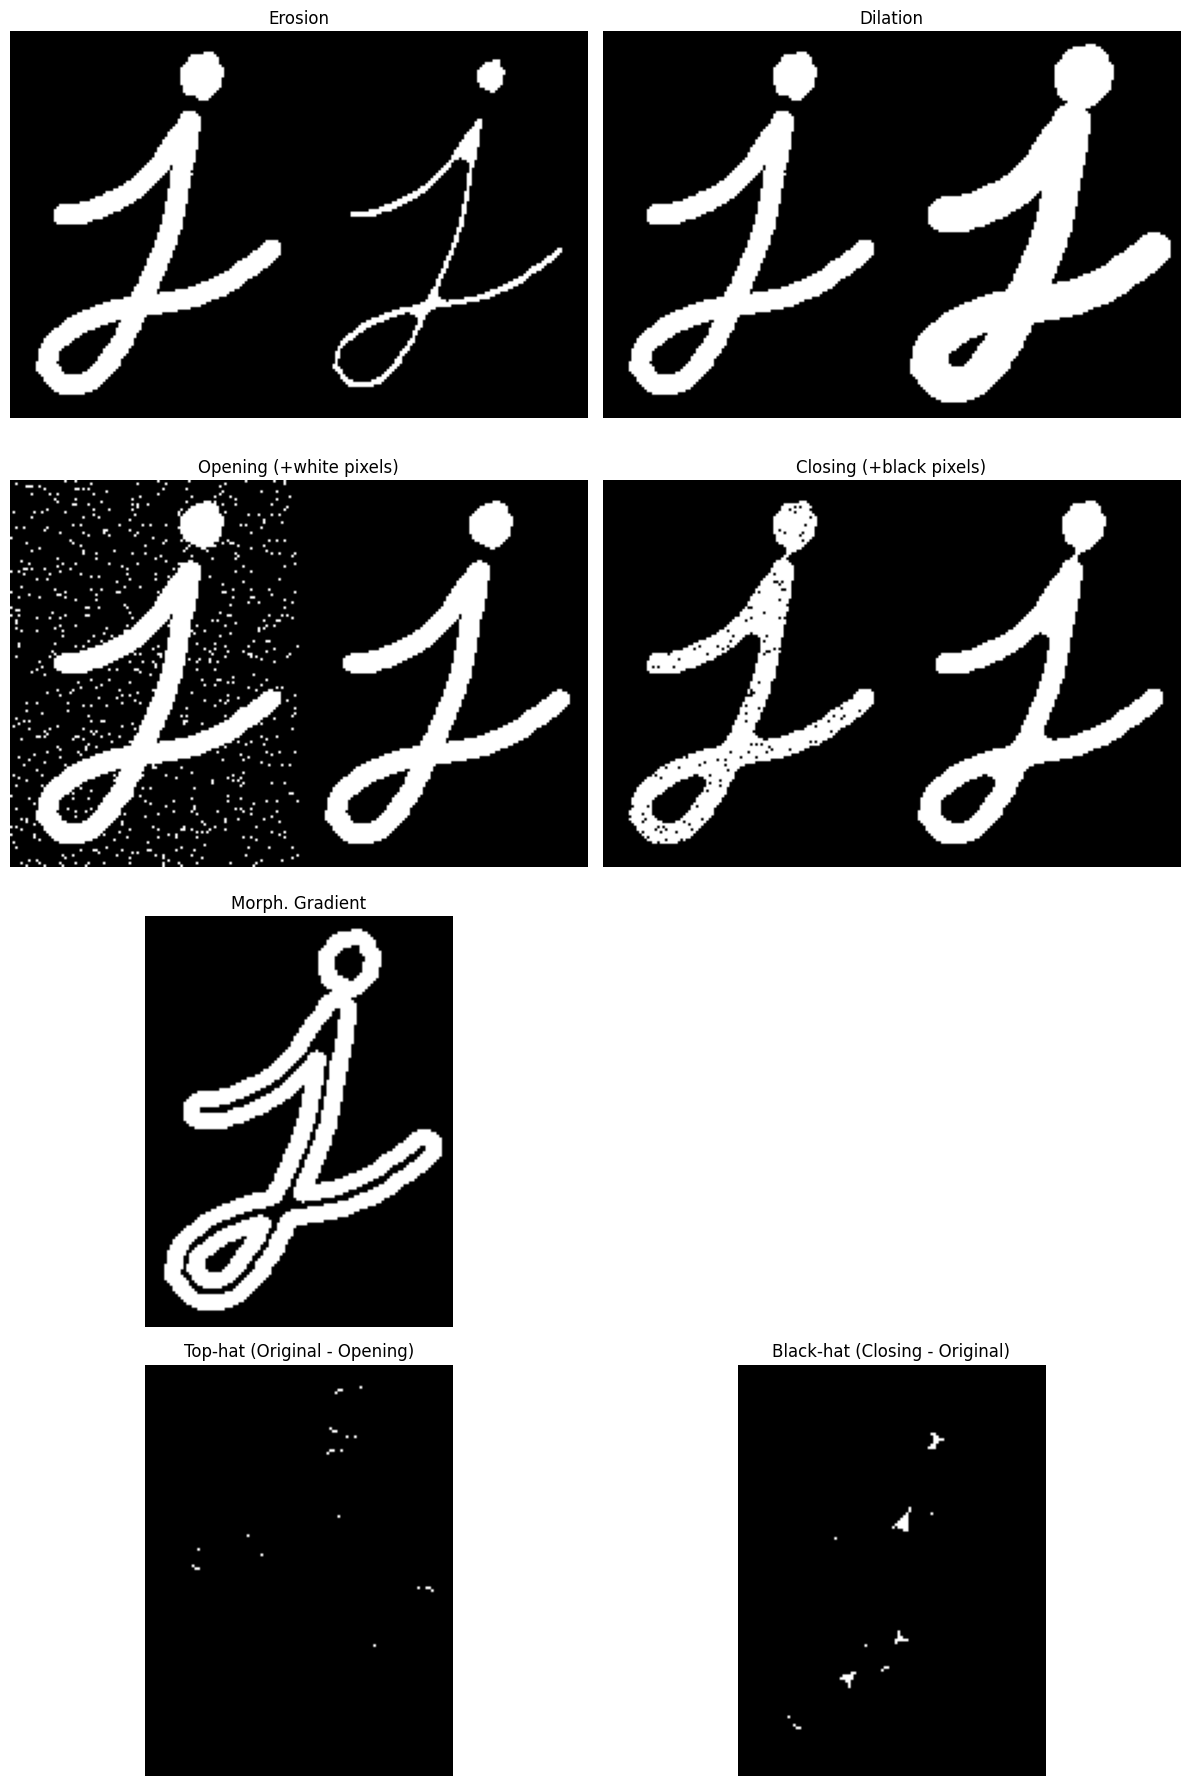

In [ ]:
images = [
    j_erode_combined, j_dilate_combined,
    j_open_combined, j_close_combined,
    j_gradient, None,
    j_tophat, j_blackhat
]

titles = [
    "Erosion",
    "Dilation",
    "Opening (+white pixels)",
    "Closing (+black pixels)",
    "Morph. Gradient", "",
    "Top-hat (Original - Opening)", "Black-hat (Closing - Original)"
]

fig, axes = plt.subplots(4, 2, figsize=(12, 18))

for ax, img, title in zip(axes.flatten(), images, titles):
    if img is not None:
        ax.imshow(img, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.tight_layout()
plt.show()